<a id='info1'></a>
## Загрузка данных

### Импорт библиотек

In [1]:
!pip install phik -q
!pip install shap -q

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import phik
import shap
import lightgbm as lgb

from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import roc_auc_score, roc_curve, auc, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeRegressor

In [3]:
RANDOM_STATE = 231224
data_load = '2020-02-01'
test_size = 0.25

### Загрузка данных

In [4]:
contract_df = pd.read_csv('/datasets/contract_new.csv', index_col=[0])
personal_df = pd.read_csv('/datasets/personal_new.csv', index_col=[0])
internet_df = pd.read_csv('/datasets/internet_new.csv', index_col=[0])
phone_df = pd.read_csv('/datasets/phone_new.csv', index_col=[0])

<a id='info2'></a>
### Обзор данных

In [5]:
contract_df.info()
contract_df.head(10)

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   BeginDate         7043 non-null   object 
 1   EndDate           7043 non-null   object 
 2   Type              7043 non-null   object 
 3   PaperlessBilling  7043 non-null   object 
 4   PaymentMethod     7043 non-null   object 
 5   MonthlyCharges    7043 non-null   float64
 6   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(6)
memory usage: 440.2+ KB


,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
customerID,,,,,,,
7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04
5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84
3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17
7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.6
9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.5
9305-CDSKC,2019-03-01,No,Month-to-month,Yes,Electronic check,99.65,1150.96
1452-KIOVK,2018-04-01,No,Month-to-month,Yes,Credit card (automatic),89.10,2058.21
6713-OKOMC,2019-04-01,No,Month-to-month,No,Mailed check,29.75,300.48
7892-POOKP,2017-07-01,No,Month-to-month,Yes,Electronic check,104.80,3573.68


In [6]:
personal_df.info()
personal_df.head(10)

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   gender         7043 non-null   object
 1   SeniorCitizen  7043 non-null   int64 
 2   Partner        7043 non-null   object
 3   Dependents     7043 non-null   object
dtypes: int64(1), object(3)
memory usage: 275.1+ KB


,gender,SeniorCitizen,Partner,Dependents
customerID,,,,
7590-VHVEG,Female,0,Yes,No
5575-GNVDE,Male,0,No,No
3668-QPYBK,Male,0,No,No
7795-CFOCW,Male,0,No,No
9237-HQITU,Female,0,No,No
9305-CDSKC,Female,0,No,No
1452-KIOVK,Male,0,No,Yes
6713-OKOMC,Female,0,No,No
7892-POOKP,Female,0,Yes,No


In [7]:
internet_df.info()
internet_df.head(10)

<class 'pandas.core.frame.DataFrame'>
Index: 5517 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   InternetService   5517 non-null   object
 1   OnlineSecurity    5517 non-null   object
 2   OnlineBackup      5517 non-null   object
 3   DeviceProtection  5517 non-null   object
 4   TechSupport       5517 non-null   object
 5   StreamingTV       5517 non-null   object
 6   StreamingMovies   5517 non-null   object
dtypes: object(7)
memory usage: 344.8+ KB


,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
customerID,,,,,,,
7590-VHVEG,DSL,No,Yes,No,No,No,No
5575-GNVDE,DSL,Yes,No,Yes,No,No,No
3668-QPYBK,DSL,Yes,Yes,No,No,No,No
7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
9237-HQITU,Fiber optic,No,No,No,No,No,No
9305-CDSKC,Fiber optic,No,No,Yes,No,Yes,Yes
1452-KIOVK,Fiber optic,No,Yes,No,No,Yes,No
6713-OKOMC,DSL,Yes,No,No,No,No,No
7892-POOKP,Fiber optic,No,No,Yes,Yes,Yes,Yes


In [8]:
phone_df.info()
phone_df.head(10)

<class 'pandas.core.frame.DataFrame'>
Index: 6361 entries, 5575-GNVDE to 3186-AJIEK
Data columns (total 1 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   MultipleLines  6361 non-null   object
dtypes: object(1)
memory usage: 99.4+ KB


,MultipleLines
customerID,
5575-GNVDE,No
3668-QPYBK,No
9237-HQITU,No
9305-CDSKC,Yes
1452-KIOVK,Yes
7892-POOKP,Yes
6388-TABGU,No
9763-GRSKD,No
7469-LKBCI,No


**Вывод:** Загрузили 4 таблицы данных, индексом указали `customerID` — идентификатор пользователя. На первый взгляд потери данных не обнаружено. В таблице `contract_df` колонку `TotalCharges` нужно перевести в _float_. 

## Исследовательский анализ и предобработка данных

<a id='preparation1'></a>
### Поиск и удаление дубликатов

In [9]:
contract_data = contract_df.copy() # создадим копию, где будут все изменения

In [10]:
contract_data.duplicated().sum()

37

In [11]:
contract_data[contract_data.duplicated(keep=False)]

,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
customerID,,,,,,,
3679-XASPY,2020-01-01,No,Month-to-month,No,Electronic check,19.45,19.45
3930-ZGWVE,2020-01-01,No,Month-to-month,No,Mailed check,19.75,19.75
1024-GUALD,2019-10-01,No,Month-to-month,Yes,Electronic check,24.80,99.2
2799-ARNLO,2019-09-01,No,Month-to-month,Yes,Electronic check,69.35,346.75
4376-KFVRS,2014-02-01,No,Two year,Yes,Credit card (automatic),114.05,8211.6
...,...,...,...,...,...,...,...
5666-CYCYZ,2018-02-01,No,Month-to-month,Yes,Electronic check,89.55,2149.2
3590-TCXTB,2020-01-01,No,Month-to-month,No,Mailed check,20.35,20.35
6230-BSUXY,2019-11-01,No,Month-to-month,Yes,Electronic check,85.00,255.0


In [12]:
contract_data.index.duplicated().sum()

0

In [13]:
def unique_data(data): # функция для вывода уникальных названий
    for table in data:
        print(data[table].unique())

In [14]:
unique_data(contract_data.drop(['MonthlyCharges', 'TotalCharges'], axis=1))

['2020-01-01' '2017-04-01' '2019-10-01' '2016-05-01' '2019-09-01'
 '2019-03-01' '2018-04-01' '2019-04-01' '2017-07-01' '2014-12-01'
 '2019-01-01' '2018-10-01' '2015-04-01' '2015-09-01' '2018-01-01'
 '2014-05-01' '2015-10-01' '2014-03-01' '2018-05-01' '2019-11-01'
 '2019-02-01' '2016-01-01' '2017-08-01' '2015-12-01' '2014-02-01'
 '2018-06-01' '2019-12-01' '2017-11-01' '2019-06-01' '2016-04-01'
 '2017-02-01' '2018-12-01' '2014-04-01' '2018-09-01' '2014-11-01'
 '2016-07-01' '2015-02-01' '2018-07-01' '2014-08-01' '2016-03-01'
 '2018-08-01' '2014-10-01' '2015-06-01' '2016-08-01' '2019-05-01'
 '2017-03-01' '2016-02-01' '2017-09-01' '2014-09-01' '2017-12-01'
 '2016-12-01' '2017-06-01' '2015-05-01' '2016-10-01' '2016-09-01'
 '2019-08-01' '2019-07-01' '2017-05-01' '2017-10-01' '2014-07-01'
 '2018-03-01' '2015-01-01' '2018-11-01' '2015-03-01' '2018-02-01'
 '2016-06-01' '2015-08-01' '2015-11-01' '2014-06-01' '2017-01-01'
 '2015-07-01' '2020-02-01' '2016-11-01' '2013-11-01' '2014-01-01'
 '2013-10-

<a id='preparation1'></a>
### Смена типа таблицы и заполнения пропусков

In [15]:
contract_data['TotalCharges'] = pd.to_numeric(contract_data['TotalCharges'], errors='coerce')

In [16]:
contract_data[contract_data['TotalCharges'].isna()]

,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
customerID,,,,,,,
4472-LVYGI,2020-02-01,No,Two year,Yes,Bank transfer (automatic),52.55,NaN
3115-CZMZD,2020-02-01,No,Two year,No,Mailed check,20.25,NaN
5709-LVOEQ,2020-02-01,No,Two year,No,Mailed check,80.85,NaN
4367-NUYAO,2020-02-01,No,Two year,No,Mailed check,25.75,NaN
1371-DWPAZ,2020-02-01,No,Two year,No,Credit card (automatic),56.05,NaN
7644-OMVMY,2020-02-01,No,Two year,No,Mailed check,19.85,NaN
3213-VVOLG,2020-02-01,No,Two year,No,Mailed check,25.35,NaN
2520-SGTTA,2020-02-01,No,Two year,No,Mailed check,20.00,NaN
2923-ARZLG,2020-02-01,No,One year,Yes,Mailed check,19.70,NaN


In [17]:
contract_data.loc[contract_data['TotalCharges'].isna(), 'TotalCharges'] = contract_data['MonthlyCharges']

In [18]:
contract_data.isna().sum()

BeginDate           0
EndDate             0
Type                0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
dtype: int64

In [19]:
contract_data.describe()

,MonthlyCharges,TotalCharges
count,7043.000000,7043.000000
mean,64.761692,2115.377573
std,30.090047,2112.678861
min,18.250000,19.050000
25%,35.500000,436.750000
50%,70.350000,1343.350000
75%,89.850000,3236.690000
max,118.750000,9221.380000


In [20]:
contract_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   BeginDate         7043 non-null   object 
 1   EndDate           7043 non-null   object 
 2   Type              7043 non-null   object 
 3   PaperlessBilling  7043 non-null   object 
 4   PaymentMethod     7043 non-null   object 
 5   MonthlyCharges    7043 non-null   float64
 6   TotalCharges      7043 non-null   float64
dtypes: float64(2), object(5)
memory usage: 698.2+ KB


In [21]:
personal_df.groupby('gender')['SeniorCitizen'].value_counts()

gender  SeniorCitizen
Female  0                2920
        1                 568
Male    0                2981
        1                 574
Name: SeniorCitizen, dtype: int64

In [22]:
unique_data(personal_df)

['Female' 'Male']
[0 1]
['Yes' 'No']
['No' 'Yes']


In [23]:
internet_df.isna().sum()

InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
dtype: int64

In [24]:
unique_data(internet_df)

['DSL' 'Fiber optic']
['No' 'Yes']
['Yes' 'No']
['No' 'Yes']
['No' 'Yes']
['No' 'Yes']
['No' 'Yes']


In [25]:
unique_data(phone_df)

['No' 'Yes']


In [26]:
phone_df.value_counts()

MultipleLines
No               3390
Yes              2971
dtype: int64

**Вывод:** провели предобработку. Создали копию основной таблицы, проверили на явные и неявные дубликаты, удалили лишние. Колонку `TotalCharges` перевели в `float`, отсутствующие заменили на месячный платеж. 

У нас есть различные признаки:

Файл contract_new.csv

- BeginDate — дата начала действия договора; Важный признак для определения продолжительности договора.
- EndDate — дата окончания действия договора; Целевой признак! Показатель времени, когда был расторгнут договор. Почему?
- Type — тип оплаты: раз в год-два или ежемесячно; Пригодится
- PaperlessBilling — электронный расчётный лист; Не очень важный признак
- PaymentMethod — тип платежа; Не очень важный признак
- MonthlyCharges — расходы за месяц; Нужный признак, ведь всё упирается в деньги
- TotalCharges — общие расходы абонента. Также

Файл personal_new.csv

- gender — пол; Возможно мужчины реже разрывают договор, а может наоборот.
- SeniorCitizen — является ли абонент пенсионером; Также, возможно реже пользуются услугами.
- Partner — есть ли у абонента супруг или супруга; Думаю важно, если человек один ему больше нужна связь для общения или поиска партнера. Или же если их двое то шанс выше, что нужен интернет для работы, развлечения одному или другому
- Dependents — есть ли у абонента дети. Также важно для учебы и развлечения.

Файл internet_new.csv

Эти данные возможно влияют на скорость, цену, разные приоритеты.
- InternetService — тип подключения; 
- OnlineSecurity — блокировка опасных сайтов; 
- OnlineBackup — облачное хранилище файлов для резервного копирования данных;
- DeviceProtection — антивирус;
- TechSupport — выделенная линия технической поддержки;
- StreamingTV — стриминговое телевидение;
- StreamingMovies — каталог фильмов.

Файл phone_new.csv

- MultipleLines — подключение телефона к нескольким линиям одновременно. Думаю не актуально и мало влияет на прекращения договора. У всех есть мобильные.

<a id='union'></a>
## Объединение данных

Объедините выбранные вами признаки в один датафрейм по ключу.

In [27]:
all_data = contract_data.merge(personal_df, on='customerID', how='left').merge(internet_df, on='customerID', how='left')\
                        .merge(phone_df, on='customerID', how='left')

In [28]:
all_data.head(10)

,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
customerID,,,,,,,,,,,,,,,,,,,
7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04,Female,0,Yes,No,DSL,No,Yes,No,No,No,No,NaN
5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84,Male,0,No,No,DSL,Yes,No,Yes,No,No,No,No
3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17,Male,0,No,No,DSL,Yes,Yes,No,No,No,No,No
7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.60,Male,0,No,No,DSL,Yes,No,Yes,Yes,No,No,NaN
9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.50,Female,0,No,No,Fiber optic,No,No,No,No,No,No,No
9305-CDSKC,2019-03-01,No,Month-to-month,Yes,Electronic check,99.65,1150.96,Female,0,No,No,Fiber optic,No,No,Yes,No,Yes,Yes,Yes
1452-KIOVK,2018-04-01,No,Month-to-month,Yes,Credit card (automatic),89.10,2058.21,Male,0,No,Yes,Fiber optic,No,Yes,No,No,Yes,No,Yes
6713-OKOMC,2019-04-01,No,Month-to-month,No,Mailed check,29.75,300.48,Female,0,No,No,DSL,Yes,No,No,No,No,No,NaN
7892-POOKP,2017-07-01,No,Month-to-month,Yes,Electronic check,104.80,3573.68,Female,0,Yes,No,Fiber optic,No,No,Yes,Yes,Yes,Yes,Yes


In [29]:
all_data.isna().sum()

BeginDate              0
EndDate                0
Type                   0
PaperlessBilling       0
PaymentMethod          0
MonthlyCharges         0
TotalCharges           0
gender                 0
SeniorCitizen          0
Partner                0
Dependents             0
InternetService     1526
OnlineSecurity      1526
OnlineBackup        1526
DeviceProtection    1526
TechSupport         1526
StreamingTV         1526
StreamingMovies     1526
MultipleLines        682
dtype: int64

In [30]:
new_data = all_data.copy()

In [31]:
new_data = new_data.fillna('No')

In [32]:
all_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   BeginDate         7043 non-null   object 
 1   EndDate           7043 non-null   object 
 2   Type              7043 non-null   object 
 3   PaperlessBilling  7043 non-null   object 
 4   PaymentMethod     7043 non-null   object 
 5   MonthlyCharges    7043 non-null   float64
 6   TotalCharges      7043 non-null   float64
 7   gender            7043 non-null   object 
 8   SeniorCitizen     7043 non-null   int64  
 9   Partner           7043 non-null   object 
 10  Dependents        7043 non-null   object 
 11  InternetService   5517 non-null   object 
 12  OnlineSecurity    5517 non-null   object 
 13  OnlineBackup      5517 non-null   object 
 14  DeviceProtection  5517 non-null   object 
 15  TechSupport       5517 non-null   object 
 16  StreamingTV       5517 non-null 

In [33]:
new_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   BeginDate         7043 non-null   object 
 1   EndDate           7043 non-null   object 
 2   Type              7043 non-null   object 
 3   PaperlessBilling  7043 non-null   object 
 4   PaymentMethod     7043 non-null   object 
 5   MonthlyCharges    7043 non-null   float64
 6   TotalCharges      7043 non-null   float64
 7   gender            7043 non-null   object 
 8   SeniorCitizen     7043 non-null   int64  
 9   Partner           7043 non-null   object 
 10  Dependents        7043 non-null   object 
 11  InternetService   7043 non-null   object 
 12  OnlineSecurity    7043 non-null   object 
 13  OnlineBackup      7043 non-null   object 
 14  DeviceProtection  7043 non-null   object 
 15  TechSupport       7043 non-null   object 
 16  StreamingTV       7043 non-null 

In [34]:
new_data[new_data.duplicated(keep=False)]

,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
customerID,,,,,,,,,,,,,,,,,,,
4376-KFVRS,2014-02-01,No,Two year,Yes,Credit card (automatic),114.05,8211.60,Male,0,Yes,Yes,Fiber optic,Yes,Yes,Yes,Yes,Yes,Yes,Yes
2866-IKBTM,2020-01-01,No,Month-to-month,No,Mailed check,19.55,19.55,Female,0,No,No,No,No,No,No,No,No,No,No
4312-KFRXN,2014-02-01,No,Two year,No,Mailed check,25.40,1828.80,Male,0,Yes,No,No,No,No,No,No,No,No,Yes
8605-ITULD,2020-01-01,No,Month-to-month,No,Mailed check,19.55,19.55,Female,0,No,No,No,No,No,No,No,No,No,No
0673-IGUQO,2020-01-01,No,Month-to-month,No,Mailed check,20.45,20.45,Male,0,No,No,No,No,No,No,No,No,No,No
2668-TZSPS,2020-01-01,No,Month-to-month,No,Mailed check,20.45,20.45,Male,0,No,No,No,No,No,No,No,No,No,No
3892-NXAZG,2014-02-01,No,Two year,Yes,Credit card (automatic),114.05,8211.60,Male,0,Yes,Yes,Fiber optic,Yes,Yes,Yes,Yes,Yes,Yes,Yes
8774-GSBUN,2014-02-01,No,Two year,No,Mailed check,25.40,1828.80,Male,0,Yes,No,No,No,No,No,No,No,No,Yes


In [35]:
new_data.index.duplicated().sum()

0

**Вывод:** После объединения таблиц получилось 7043 строк и 1526 клиентов из таблицы с интеренет и 682 из телефонов нет информации, заменили на 'No'.

## Исследовательский анализ и предобработка данных объединённого датафрейма

<a id='generation'></a>
### Сгенерируем новые признаки

In [36]:
new_data['target'] = new_data['EndDate']

In [37]:
new_data.loc[new_data['target'] != 'No', 'target'] = 'Yes'

In [38]:
new_data['target'].unique()

array(['No', 'Yes'], dtype=object)

In [39]:
label_encoder = LabelEncoder()
new_data['target'] = label_encoder.fit_transform(new_data['target'])

In [40]:
new_data.loc[new_data['EndDate'] == 'No', 'EndDate'] = data_load
new_data

,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines,target
customerID,,,,,,,,,,,,,,,,,,,,
7590-VHVEG,2020-01-01,2020-02-01,Month-to-month,Yes,Electronic check,29.85,31.04,Female,0,Yes,No,DSL,No,Yes,No,No,No,No,No,0
5575-GNVDE,2017-04-01,2020-02-01,One year,No,Mailed check,56.95,2071.84,Male,0,No,No,DSL,Yes,No,Yes,No,No,No,No,0
3668-QPYBK,2019-10-01,2020-02-01,Month-to-month,Yes,Mailed check,53.85,226.17,Male,0,No,No,DSL,Yes,Yes,No,No,No,No,No,0
7795-CFOCW,2016-05-01,2020-02-01,One year,No,Bank transfer (automatic),42.30,1960.60,Male,0,No,No,DSL,Yes,No,Yes,Yes,No,No,No,0
9237-HQITU,2019-09-01,2020-02-01,Month-to-month,Yes,Electronic check,70.70,353.50,Female,0,No,No,Fiber optic,No,No,No,No,No,No,No,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6840-RESVB,2018-02-01,2020-02-01,One year,Yes,Mailed check,84.80,2035.20,Male,0,Yes,Yes,DSL,Yes,No,Yes,Yes,Yes,Yes,Yes,0
2234-XADUH,2014-02-01,2020-02-01,One year,Yes,Credit card (automatic),103.20,7430.40,Female,0,Yes,Yes,Fiber optic,No,Yes,Yes,No,Yes,Yes,Yes,0
4801-JZAZL,2019-03-01,2020-02-01,Month-to-month,Yes,Electronic check,29.60,325.60,Female,0,Yes,Yes,DSL,Yes,No,No,No,No,No,No,0


In [41]:
new_data['BeginDate'] = pd.to_datetime(new_data['BeginDate'])
new_data['EndDate'] = pd.to_datetime(new_data['EndDate'])

In [42]:
def calculate_months(row):
    return (row['EndDate'].year - row['BeginDate'].year) * 12 + (row['EndDate'].month - row['BeginDate'].month)

new_data['month'] = new_data.apply(calculate_months, axis=1)

In [43]:
new_data['Days'] = (new_data['EndDate'] - new_data['BeginDate']).dt.days

In [44]:
new_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 22 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   BeginDate         7043 non-null   datetime64[ns]
 1   EndDate           7043 non-null   datetime64[ns]
 2   Type              7043 non-null   object        
 3   PaperlessBilling  7043 non-null   object        
 4   PaymentMethod     7043 non-null   object        
 5   MonthlyCharges    7043 non-null   float64       
 6   TotalCharges      7043 non-null   float64       
 7   gender            7043 non-null   object        
 8   SeniorCitizen     7043 non-null   int64         
 9   Partner           7043 non-null   object        
 10  Dependents        7043 non-null   object        
 11  InternetService   7043 non-null   object        
 12  OnlineSecurity    7043 non-null   object        
 13  OnlineBackup      7043 non-null   object        
 14  DeviceProtecti

In [45]:
new_data['target'].value_counts()

0    5942
1    1101
Name: target, dtype: int64

In [46]:
new_data.describe()

,MonthlyCharges,TotalCharges,SeniorCitizen,target,month,Days
count,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000
mean,64.761692,2115.377573,0.162147,0.156325,29.495385,898.555729
std,30.090047,2112.678861,0.368612,0.363189,22.446726,683.130510
min,18.250000,19.050000,0.000000,0.000000,0.000000,0.000000
25%,35.500000,436.750000,0.000000,0.000000,9.000000,276.000000
50%,70.350000,1343.350000,0.000000,0.000000,25.000000,761.000000
75%,89.850000,3236.690000,0.000000,0.000000,48.000000,1461.000000
max,118.750000,9221.380000,1.000000,1.000000,76.000000,2314.000000


In [47]:
new_data.isna().sum()

BeginDate           0
EndDate             0
Type                0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
MultipleLines       0
target              0
month               0
Days                0
dtype: int64

<a id='charts'></a>
### Графики соотношений для ушедших и оставшихся клиентов

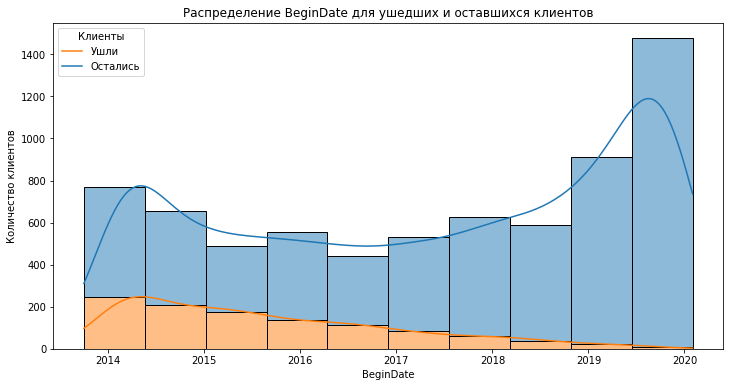

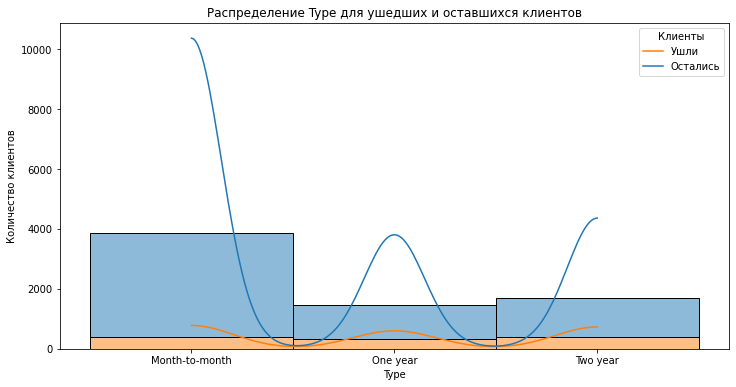

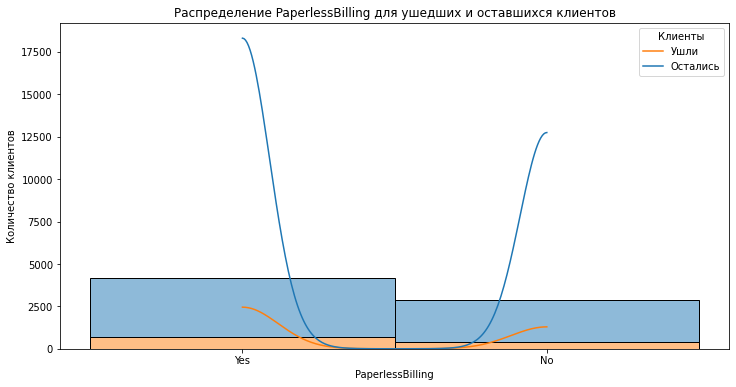

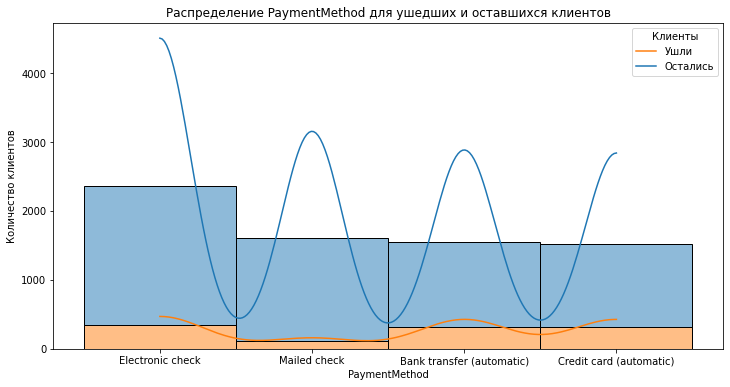

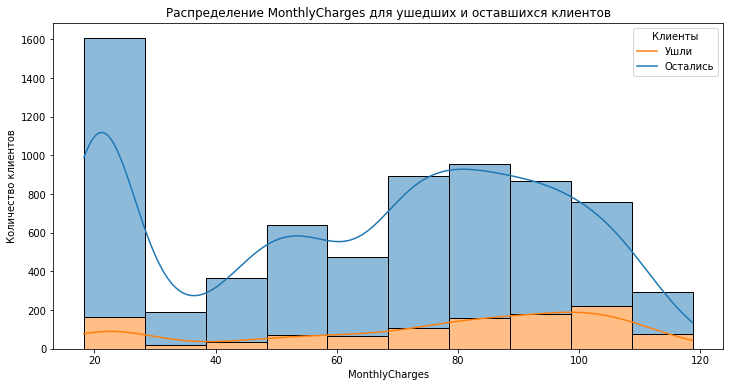

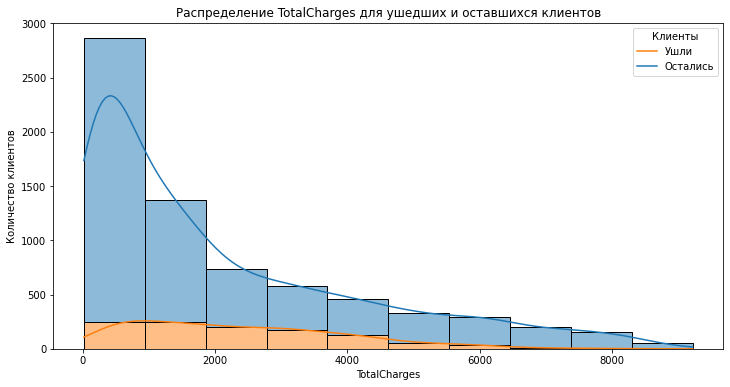

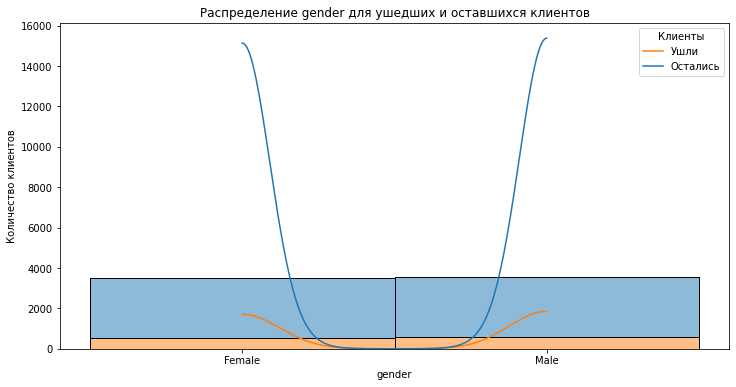

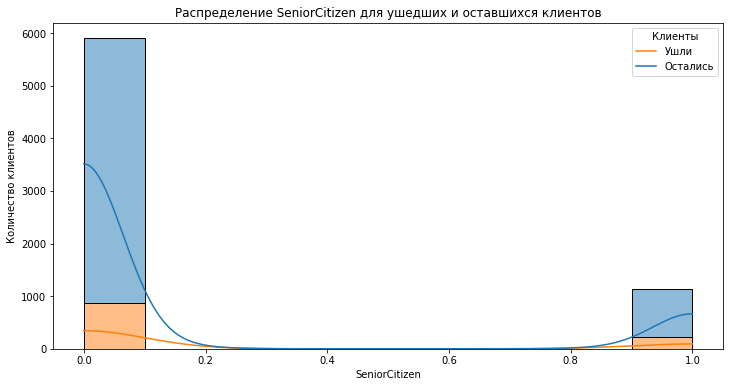

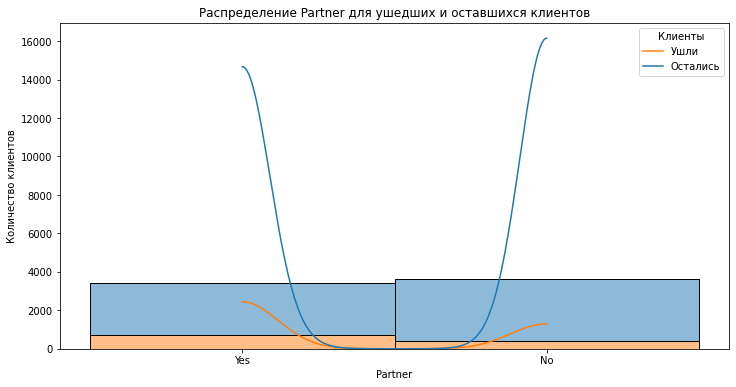

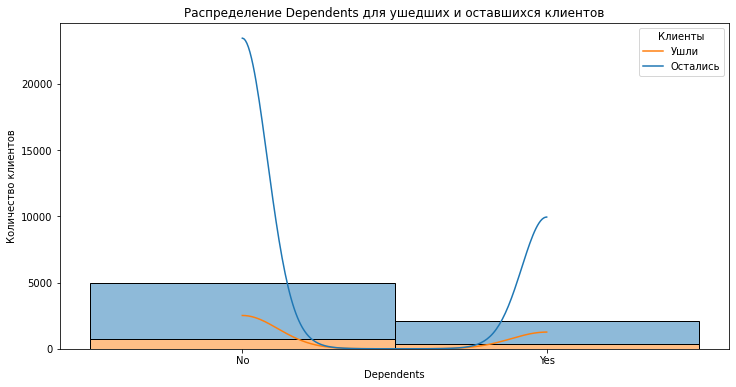

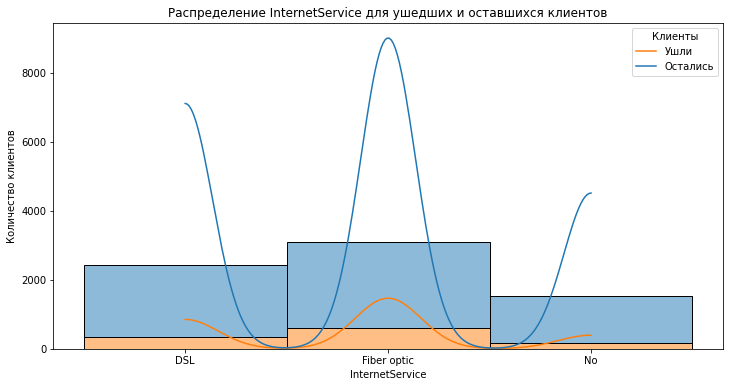

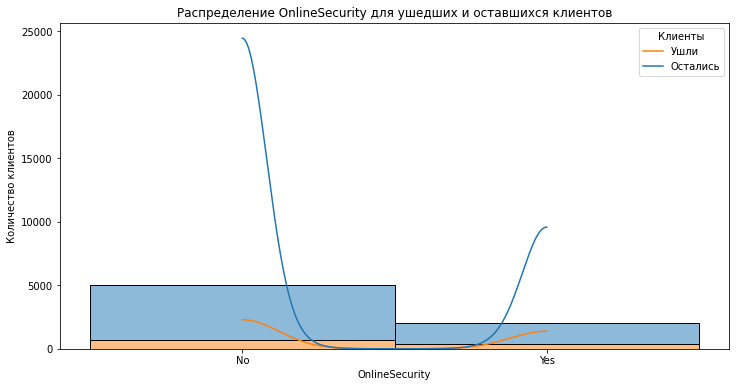

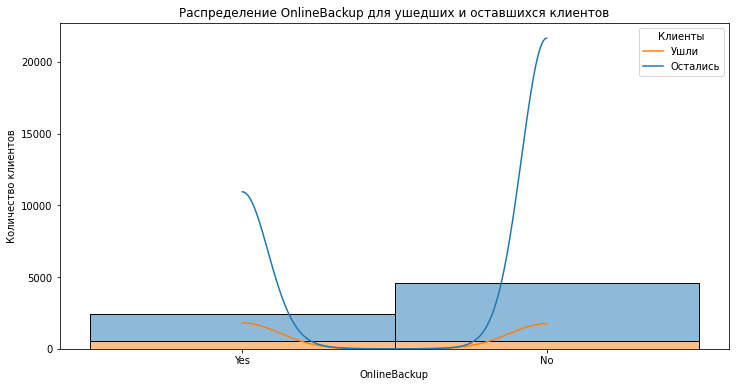

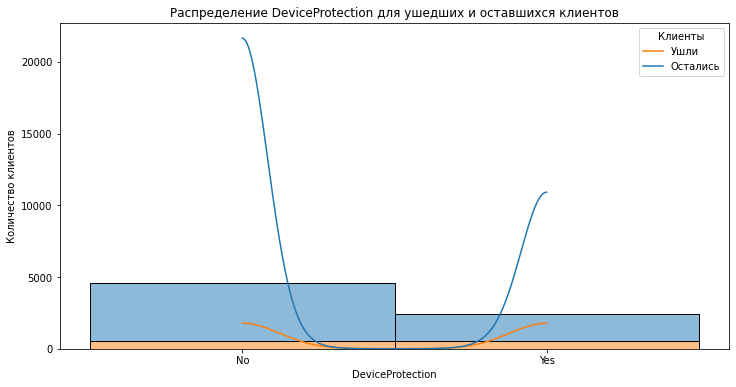

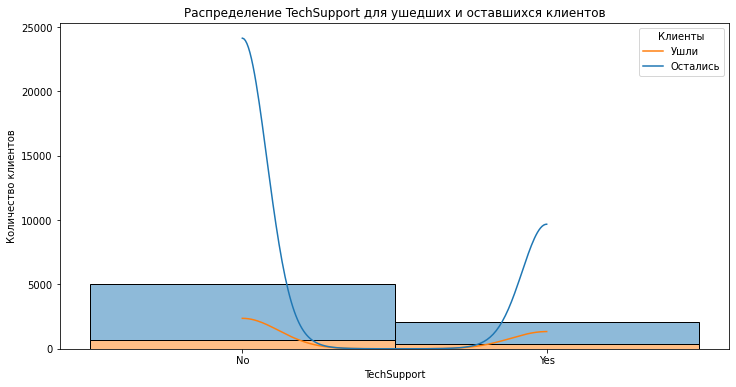

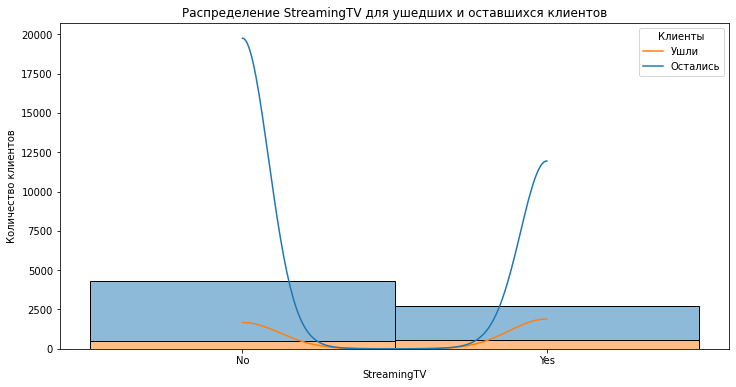

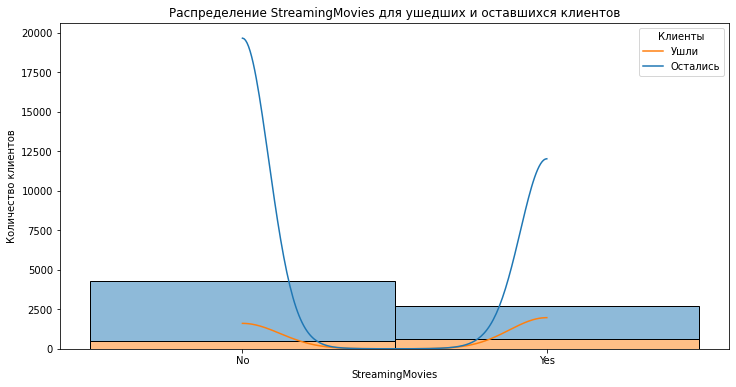

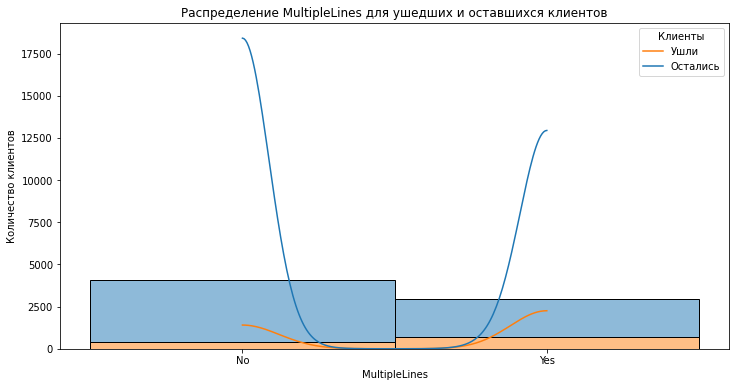

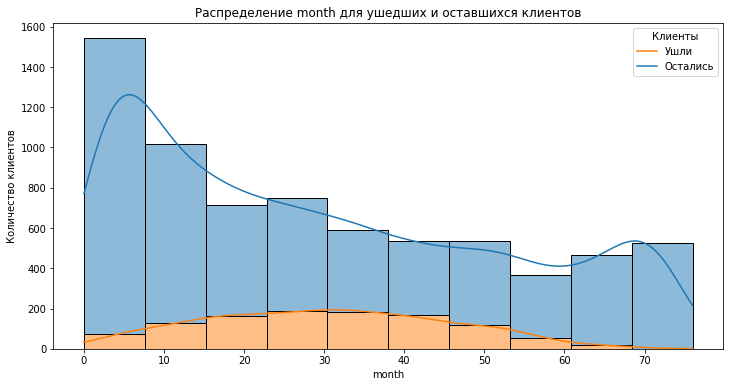

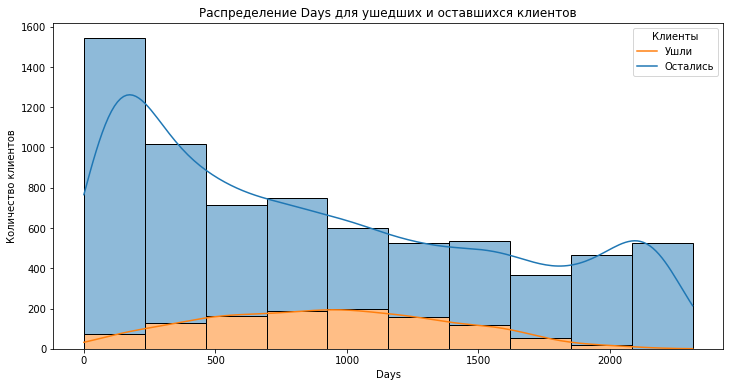

In [48]:
columns = new_data.drop(['target', 'EndDate'], axis=1).columns

for col in columns:
    plt.figure(figsize=(12, 6))
    sns.histplot(data=new_data, x=col, hue='target', multiple='stack', bins=10, kde=True)
    plt.title(f'Распределение {col} для ушедших и оставшихся клиентов')
    plt.xlabel(col)
    plt.ylabel('Количество клиентов')
    plt.legend(title='Клиенты', labels=['Ушли', 'Остались'])
    plt.show()

**Вывод:** Исходя из графиков видно, что начиная с 2014 года, видимо открытие компании, был прирост клиентов, потом пошел спад и с 2017 снова начался прирост клиентов вплоть до 2020 года. Но при этом большинство "ушедших" клиентов, это "старые" клиенты, которые заключили контракт с 2014 года. Но и уход клиентов я считаю нормальным, т.к. он идет на спад из года в год, т.е. компания относительно "делает всё правильно".

Конечно же, большинство клиентов расторгнувших договор, это те, у кого месячная и общая оплата выше. Соответственно пик приходится на 100 в месяц и 2500 общая.

<a id='generation'></a>
### Коэффициенты корреляции heatmap

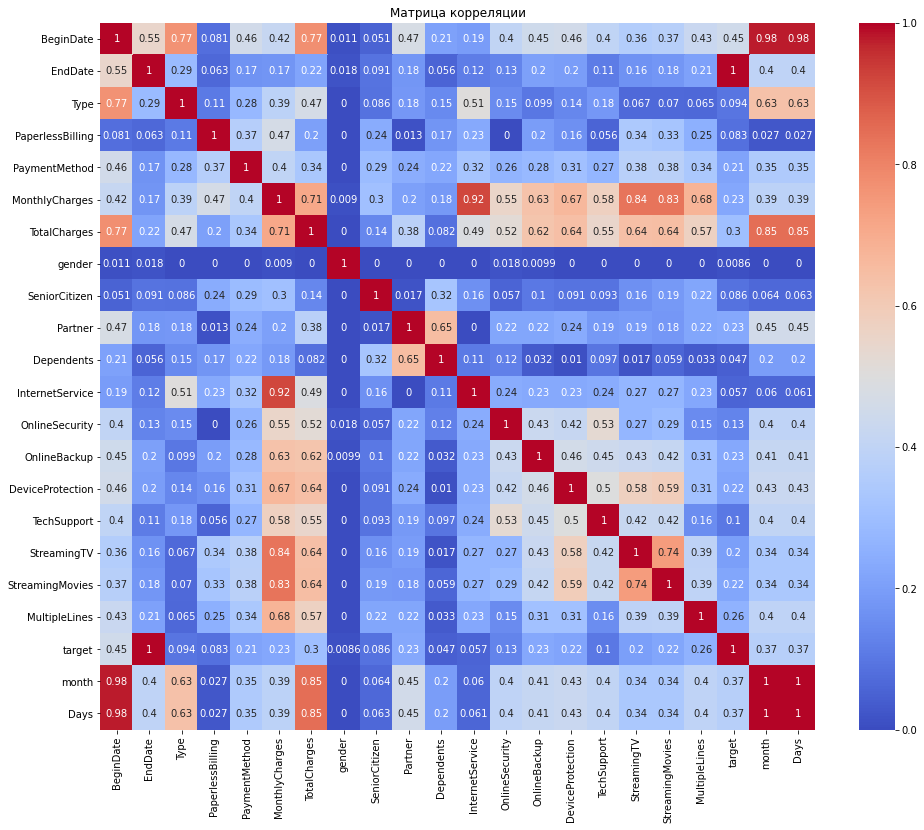

In [49]:
list_columns = ['MonthlyCharges', 'TotalCharges', 'SeniorCitizen', 'target', 'month', 'Days']
corr_matrix = new_data.phik_matrix(interval_cols = list_columns)

plt.figure(figsize=(16, 13))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Матрица корреляции')
plt.show()

**Вывод:** Новые признаки `month` и `days` не берем в расчет, т.к. это производные `Begin` и `End Dates`. 

Конец контракта `EndDate` в большей степени зависил от начала `BeginDate`. В свою очередь начало контракта зависило от типа отплаты `Type`, помесячно(предпочтительная среди клиентов) или раз в 1-2 года, а от типа соответственно и сумма оплаты `TotalCharges`, на которую влияют доп. функции(_OnlineSecurity — блокировка опасных сайтов; OnlineBackup — облачное хранилище файлов для резервного копирования данных; DeviceProtection — антивирус; TechSupport — выделенная линия технической поддержки; StreamingTV — стриминговое телевидение; StreamingMovies — каталог фильмов; MultipleLines — подключение телефона к нескольким линиям одновременно._)

Общая сумма конечно же связана с месячной оплатой `MonthlyCharges`, а месячная сумма зависит от `InternetService` типа подключения DSL или Fiber optic(больше клиентов), от функций контрактов, в данном случае больше от просмотра ТВ `StreamingTV` или фильмов `StreamingMovies`, которые тоже взаимосвязаны между собой, и в меньшей степени функцией телефона `MultipleLines` и наличием антивируса `DeviceProtection`. 

Также можно заметить зависимость между наличием партнеров `Partner` и детей `Dependents`.

## Подготовка данных

<a id='split'></a>
### Разделение датасета на `train` и `test`

In [50]:
X = new_data.drop(['BeginDate', 'EndDate', 'target', 'month'], axis=1)
y = new_data['target']

In [51]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=RANDOM_STATE)

In [52]:
def get_data_info(data):
    display(data.sample(5))
    display(data.info())
    display(data.describe(include='all'))

In [53]:
get_data_info(X_train)

,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines,Days
customerID,,,,,,,,,,,,,,,,,,
4538-WNTMJ,One year,No,Mailed check,24.95,1147.7,Female,0,Yes,Yes,No,No,No,No,No,No,No,Yes,1401
0257-KXZGU,Month-to-month,No,Bank transfer (automatic),62.45,1998.4,Female,0,Yes,Yes,DSL,No,Yes,Yes,No,No,No,Yes,975
3688-FTHLT,Month-to-month,Yes,Bank transfer (automatic),63.05,1008.8,Female,0,No,No,DSL,No,No,No,No,No,Yes,Yes,488
4853-RULSV,Two year,Yes,Credit card (automatic),104.00,3848.0,Male,0,No,No,Fiber optic,Yes,No,No,Yes,Yes,Yes,Yes,1124
5599-HVLTW,Month-to-month,Yes,Bank transfer (automatic),80.35,1124.9,Female,1,No,No,Fiber optic,No,No,Yes,No,No,No,Yes,427


<class 'pandas.core.frame.DataFrame'>
Index: 5282 entries, 7971-HLVXI to 9548-ZMVTX
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Type              5282 non-null   object 
 1   PaperlessBilling  5282 non-null   object 
 2   PaymentMethod     5282 non-null   object 
 3   MonthlyCharges    5282 non-null   float64
 4   TotalCharges      5282 non-null   float64
 5   gender            5282 non-null   object 
 6   SeniorCitizen     5282 non-null   int64  
 7   Partner           5282 non-null   object 
 8   Dependents        5282 non-null   object 
 9   InternetService   5282 non-null   object 
 10  OnlineSecurity    5282 non-null   object 
 11  OnlineBackup      5282 non-null   object 
 12  DeviceProtection  5282 non-null   object 
 13  TechSupport       5282 non-null   object 
 14  StreamingTV       5282 non-null   object 
 15  StreamingMovies   5282 non-null   object 
 16  MultipleLines     5282 non-null 

None

,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines,Days
count,5282,5282,5282,5282.000000,5282.000000,5282,5282.000000,5282,5282,5282,5282,5282,5282,5282,5282,5282,5282,5282.000000
unique,3,2,4,NaN,NaN,2,NaN,2,2,3,2,2,2,2,2,2,2,NaN
top,Month-to-month,Yes,Electronic check,NaN,NaN,Male,NaN,No,No,Fiber optic,No,No,No,No,No,No,No,NaN
freq,2925,3129,1783,NaN,NaN,2663,NaN,2779,3727,2332,3769,3451,3518,3765,3292,3253,3043,NaN
mean,NaN,NaN,NaN,64.658179,2100.503764,NaN,0.163953,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,890.112079
std,NaN,NaN,NaN,30.093480,2115.353071,NaN,0.370268,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,681.856457
min,NaN,NaN,NaN,18.400000,19.190000,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000
25%,NaN,NaN,NaN,35.212500,427.692500,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,276.000000
50%,NaN,NaN,NaN,70.400000,1315.400000,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,760.000000
75%,NaN,NaN,NaN,89.700000,3205.105000,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1432.000000


In [54]:
get_data_info(X_test)

,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines,Days
customerID,,,,,,,,,,,,,,,,,,
7515-LODFU,Two year,No,Credit card (automatic),20.30,1400.70,Male,1,No,No,No,No,No,No,No,No,No,No,2102
6543-XRMYR,Month-to-month,Yes,Electronic check,99.70,3399.77,Female,1,No,No,Fiber optic,No,Yes,No,No,Yes,Yes,Yes,945
6923-JHPMP,Month-to-month,Yes,Electronic check,80.45,167.34,Female,0,No,No,Fiber optic,Yes,No,Yes,No,No,No,No,62
3720-DBRWL,Two year,Yes,Credit card (automatic),83.85,4276.35,Male,0,Yes,No,DSL,Yes,Yes,Yes,Yes,Yes,Yes,No,1553
1567-DSCIC,Month-to-month,Yes,Electronic check,94.00,879.84,Male,0,No,No,Fiber optic,No,Yes,Yes,No,Yes,No,Yes,276


<class 'pandas.core.frame.DataFrame'>
Index: 1761 entries, 2876-VBBBL to 6365-MTGZX
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Type              1761 non-null   object 
 1   PaperlessBilling  1761 non-null   object 
 2   PaymentMethod     1761 non-null   object 
 3   MonthlyCharges    1761 non-null   float64
 4   TotalCharges      1761 non-null   float64
 5   gender            1761 non-null   object 
 6   SeniorCitizen     1761 non-null   int64  
 7   Partner           1761 non-null   object 
 8   Dependents        1761 non-null   object 
 9   InternetService   1761 non-null   object 
 10  OnlineSecurity    1761 non-null   object 
 11  OnlineBackup      1761 non-null   object 
 12  DeviceProtection  1761 non-null   object 
 13  TechSupport       1761 non-null   object 
 14  StreamingTV       1761 non-null   object 
 15  StreamingMovies   1761 non-null   object 
 16  MultipleLines     1761 non-null 

None

,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines,Days
count,1761,1761,1761,1761.000000,1761.000000,1761,1761.000000,1761,1761,1761,1761,1761,1761,1761,1761,1761,1761,1761.000000
unique,3,2,4,NaN,NaN,2,NaN,2,2,3,2,2,2,2,2,2,2,NaN
top,Month-to-month,Yes,Electronic check,NaN,NaN,Male,NaN,Yes,No,Fiber optic,No,No,No,No,No,No,No,NaN
freq,950,1042,582,NaN,NaN,892,NaN,899,1206,764,1255,1163,1103,1234,1044,1058,1029,NaN
mean,NaN,NaN,NaN,65.072175,2159.990557,NaN,0.156729,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,923.881885
std,NaN,NaN,NaN,30.086156,2104.605959,NaN,0.363648,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,686.509201
min,NaN,NaN,NaN,18.250000,19.050000,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000
25%,NaN,NaN,NaN,38.600000,481.500000,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,306.000000
50%,NaN,NaN,NaN,70.150000,1416.000000,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,792.000000
75%,NaN,NaN,NaN,90.400000,3333.960000,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1492.000000


<a id='metrics'></a>
### Кодирование категориальных и количественных признаков

In [55]:
ohe_columns = ['Type', 'PaperlessBilling', 'PaymentMethod', 'gender', 'Partner', 'Dependents', 'InternetService', 
               'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 
               'MultipleLines', 'SeniorCitizen']
num_columns = ['MonthlyCharges', 'TotalCharges', 'Days']

In [56]:
preprocessor = ColumnTransformer(
    transformers=[
        ('ohe', OneHotEncoder(drop='first', handle_unknown='error', sparse=False), ohe_columns),
        ('num', StandardScaler(), num_columns)
    ],
    remainder='passthrough'
)

## Обучение моделей машинного обучения

In [57]:
train_models = []

### pipeline + gridsearchcv

In [58]:
def model_training(model, parameters):
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('model', model)])
    gsearch = GridSearchCV(pipeline, cv=5, n_jobs=-1, param_grid=parameters , scoring = 'roc_auc', verbose = False)
    gsearch.fit(X_train, y_train)
    best_score = gsearch.best_score_
    best_params = gsearch.best_params_
    print('Лучший результат:', best_score)
    print('Лучшие параметры:', best_params)
    train_models.append([model, best_score, best_params])
    return gsearch

<a id='model1'></a>
### LogisticRegression

In [59]:
lr_mod = model_training(LogisticRegression(random_state=RANDOM_STATE), {'model__C':[0.1, 1.0, 10.0]})

Лучший результат: 0.7719233855334677
Лучшие параметры: {'model__C': 10.0}


<a id='model2'></a>
### LGBMClassifier

In [60]:
lgbmc_mod = model_training(lgb.LGBMClassifier(random_state=RANDOM_STATE), {'model__num_leaves': [5, 10, 50], 
                                                                           'model__n_estimators': [40, 80]})

Лучший результат: 0.8696658955949461
Лучшие параметры: {'model__n_estimators': 80, 'model__num_leaves': 50}


<a id='model3'></a>
### RandomForestClassifier

In [61]:
rfc_mod = model_training(RandomForestClassifier(random_state=RANDOM_STATE), {'model__n_estimators': [50, 100, 300],
                                                                             'model__max_depth': [None, 10, 20, 30]})

Лучший результат: 0.8309472212691589
Лучшие параметры: {'model__max_depth': 10, 'model__n_estimators': 300}


In [62]:
result_models = pd.DataFrame(train_models, columns=['model', 'roc_auc_score', 'best_params'])
result_models.sort_values('roc_auc_score', ascending=False)

,model,roc_auc_score,best_params
1,LGBMClassifier(random_state=231224),0.869666,"{'model__n_estimators': 80, 'model__num_leaves..."
2,RandomForestClassifier(random_state=231224),0.830947,"{'model__max_depth': 10, 'model__n_estimators'..."
0,LogisticRegression(random_state=231224),0.771923,{'model__C': 10.0}


**Вывод:** Исходя из полученных метрик, лучший результат на тренировочных данных показала модель `LGBMClassifier` с метрикой рок кривой самой близкой к единице ≈ 0,87. ROC_AUC отлично подходит для бинарной классификации с несбалансированной выборкой.

<a id='best'></a>
## Выбор лучшей модели

### Качество лучшей модели на тестовой выборке

In [63]:
y_pred = lgbmc_mod.predict_proba(X_test)[:, 1]
result = roc_auc_score(y_test, y_pred)
print('ROC-AUC на тестовых данных:', result)

ROC-AUC на тестовых данных: 0.8683004138314657


### график ROC-кривой на тестовой выборке

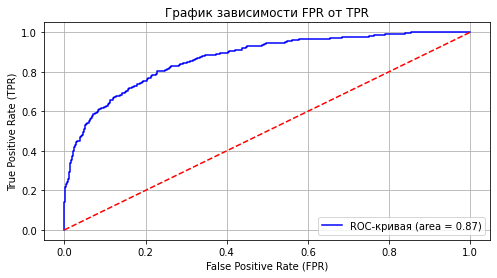

In [64]:
fpr, tpr, threshold = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 4))
plt.plot(fpr, tpr, color='blue', label='ROC-кривая (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='red', linestyle='--')  # Линия случайного угадывания
plt.title("График зависимости FPR от TPR")
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.legend(loc='lower right')
plt.grid()
plt.show()

### Матрица ошибок

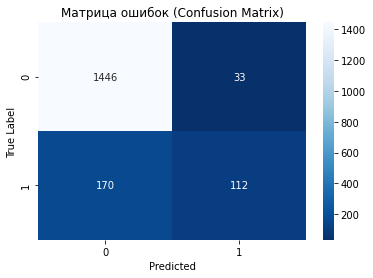

In [65]:
y_pred_classes = (y_pred >= 0.5).astype(int)
cm = confusion_matrix(y_test, y_pred_classes)

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues_r')
plt.xlabel('Predicted')
plt.ylabel('True Label')
plt.title('Матрица ошибок (Confusion Matrix)')
plt.show()

### Важность признаков для лучшей модели

/opt/conda/lib/python3.9/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')


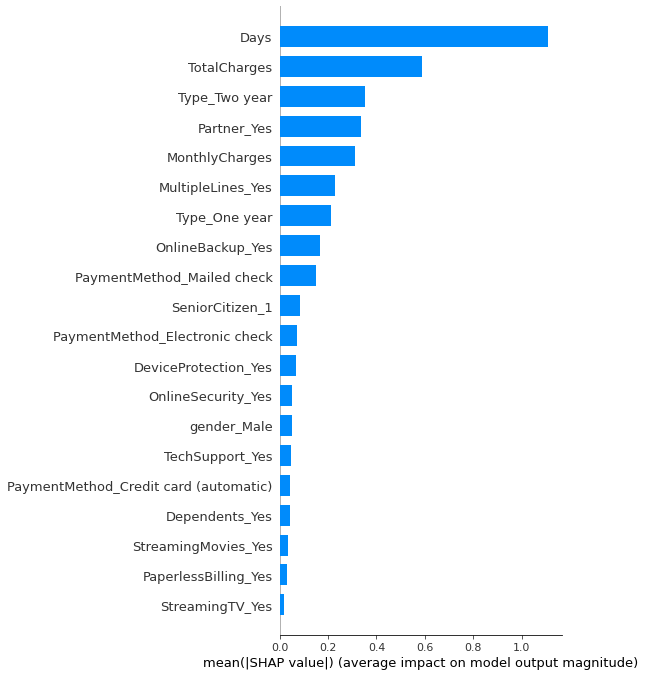

In [66]:
best_model = lgbmc_mod.best_estimator_.named_steps['model']

explainer = shap.TreeExplainer(best_model)

X_test_transformed = lgbmc_mod.best_estimator_.named_steps['preprocessor'].transform(X_test)
ohe_feature_names = lgbmc_mod.best_estimator_.named_steps['preprocessor'].named_transformers_['ohe'].get_feature_names(input_features=ohe_columns)
feature_names = np.concatenate([ohe_feature_names, num_columns])

X_test_2 = pd.DataFrame(X_test_transformed, columns=feature_names)

shap_values = explainer.shap_values(X_test_2) 

plt.figure(figsize=(10, 6))
shap.summary_plot(shap_values, X_test_2, plot_type="bar")

Наглядно видно какие признаки имеют большее влияние на модель.

<a id='conclusion'></a>
## Общий вывод и рекомендации заказчику

Сделайте общий вывод о проделанной работе: опишите основные этапы работы, полученные результаты и дайте рекомендации для бизнеса.

**Вывод:** Загрузили данные, провели предварительный обзор данных, а это, пять таблиц, проверили их на пропуски, ошибки и аномалии. Затем соединили их в одну таблицу, исключили неполные, неинформативные данные. Провели исследовательский анализ, построили графики сравнения соотношений для ушедших и оставшихся клиентов, построили матрицу коррелиции, чтобы рассмотреть взаимосвязь между данными. А также создали новые признаки для лучшего обучения моделей. Разделили данные на тренировочную и тестовую выборки соотношением 1 к 4. Перекодировали категориальные признаки и обучили 3 модели: _Линейная модель_: `LogisticRegression`, _Модель градиентного бустинга_: `LGBMClassifier`, _Ансамблевая модель_: `RandomForestClassifier` для которых подобрали различные гиперпараметры, а методом `GridSearchCV` с помощью пайплайна и метрики оценки `roc_auc_score` выбрали лучшую модель. На тренировочных данных хорошие результаты, ≈ 0,87, показала модель бустера Lightgbm, ее и использовали на тестовых данных.
Получили работающую модель для прогноза оттока клиентов с точностью в ≈ 87%.

Судя по последним годам у компании вроде все хорошо, клиенты растут, отток минимальный.

**Рекомендации:** Обратить внимание на "старых" клиентов, которые уже давно пользуются услугами, особенно от 1 до 3 лет, дать им возможность привилегий, скидок или доп.опций. Возможно некоторые старые, стали новыми? А также обратить на ценовую политику и ценообразование, ведь больше клиентов расторгнувших договор, те у кого месячные расходы превысели 90 или общие свыше 2000. Возможно предложить клиентам перейти на более дешевые услуги, или исключить неиспользуемые услуги для уменьшения сумм оплаты.